# Практическое задание 6
## КМБО-01-20, Гребнев Никита, Большаков Михаил  
## Тема №23 "Употребление алкоголя учащимися"

## Предварительная обработка данных

Считываем данныеиз файлов также, как делали это в работе 5:

In [1]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('student-por.csv')
df2 = pd.read_csv('student-mat.csv')

In [2]:
df = df1.append(df2, ignore_index=True)

Нормируем числовые признаки, преобразуем текстовые значения в числовые:

In [3]:
import math
numeric = ['age', 'absences', 'G1', 'G2', 'G3']
for column in numeric:
    df[column] = (df[column] - df[column].mean())/(math.sqrt(df[column].var()))
    
texted = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
for column in texted:
    cur_set = set(df[column])
    i = 0
    for item in cur_set:
        df[column] = df[column].replace(item, i)
        i = i + 1

## 1. Построить прогноз итогового балла учащегося.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x = df.drop('G3', axis=1)
y = df.loc[:, df.columns.isin(['G3'])]

Избавимся от мультиколлинеарности:

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def update_vif():
    global x
    vif_data = pd.DataFrame()
    vif_data["column_name"] = x.columns
    vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
    vif_data = vif_data.loc[vif_data['VIF'] >= 10.0]
    return vif_data

Поочерёдное удаление из `x` всех столбцов с максимальным VIF, пока VIF $\geq$ 10

In [6]:
vif_data = update_vif()
while not (vif_data.empty):
    a = vif_data[vif_data["VIF"] == vif_data["VIF"].max()]["column_name"]
    print("Удаляемый признак:", a.array[0])
    x = x.drop(a, axis=1)
    vif_data = update_vif()

Удаляемый признак: famrel
Удаляемый признак: Medu
Удаляемый признак: higher
Удаляемый признак: goout
Удаляемый признак: freetime


In [7]:
x

,school,sex,age,address,famsize,Pstatus,Fedu,Mjob,Fjob,reason,...,activities,nursery,internet,romantic,Dalc,Walc,health,absences,G1,G2
0,1,1,1.027397,1,1,1,4,0,2,2,...,0,1,0,0,1,1,3,-0.070027,-3.758673,-0.074936
1,1,1,0.220929,1,1,0,1,0,3,2,...,0,0,1,0,1,1,3,-0.392087,-0.741974,-0.074936
2,1,1,-1.392007,1,0,0,1,0,3,1,...,0,1,1,0,2,3,3,0.252034,0.263592,0.533879
3,1,1,-1.392007,1,1,0,2,4,1,0,...,1,1,1,1,1,1,5,-0.714147,0.933969,0.838287
4,1,1,-0.585539,1,1,0,3,3,3,0,...,0,1,0,0,1,2,5,-0.714147,-0.071597,0.533879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,0,0,2.640333,1,0,1,2,1,1,2,...,0,1,0,0,4,5,4,1.057185,-0.741974,-0.683750
1040,0,0,0.220929,1,0,0,1,1,1,2,...,0,0,1,0,3,4,2,-0.231057,0.933969,1.447102
1041,0,0,3.446801,0,1,0,1,3,3,2,...,0,0,0,0,3,3,3,-0.231057,-0.406786,-0.988158
1042,0,0,1.027397,0,0,0,2,1,3,2,...,0,0,1,0,3,4,5,-0.714147,-0.071597,0.229472


Теперь разделим данные на обучающую и тестовую выборку, построим модель линейной регрессии:

In [8]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=.3, random_state=42)

model = LinearRegression().fit(x_train,y_train)
print ("R^2 =", model.score(x_validation,y_validation))

R^2 = 0.8365063567012032


In [9]:
for i in range(len(x.columns)):
     model.coef_[0][i] = round(model.coef_[0][i], 3) #float('{:.5f}'.format(a[i]))
model.intercept_[0] = round(model.intercept_[0], 3)

In [10]:
print(df['G3'].min())
print(df['G3'].max())

-2.93468389976102
2.2402337446110847


In [11]:
print('G3: ')
print(model.intercept_[0], "+")
for i in range(len(x.columns)):
    print(model.coef_[0][i], end='')
    print(' * '+x.columns[i], "+")

G3: 
-0.063 +
-0.039 * school +
0.012 * sex +
-0.014 * age +
0.024 * address +
0.02 * famsize +
0.005 * Pstatus +
-0.01 * Fedu +
-0.002 * Mjob +
0.021 * Fjob +
0.02 * reason +
0.022 * guardian +
0.05 * traveltime +
-0.02 * studytime +
-0.106 * failures +
0.072 * schoolsup +
0.047 * famsup +
-0.066 * paid +
-0.033 * activities +
-0.012 * nursery +
-0.008 * internet +
-0.033 * romantic +
-0.009 * Dalc +
0.007 * Walc +
-0.007 * health +
0.05 * absences +
0.124 * G1 +
0.799 * G2 +


Итоговый балл G3 = **-0.012 +
0.039 * school +
0.014 * sex +
-0.015 * age +
-0.023 * address +
0.021 * famsize +
-0.004 * Pstatus +
-0.008 * Fedu +
0.006 * Mjob +
-0.017 * Fjob +
0.014 * reason +
0.02 * guardian +
0.05 * traveltime +
-0.02 * studytime +
-0.104 * failures +
0.072 * schoolsup +
0.046 * famsup +
-0.071 * paid +
-0.031 * activities +
-0.012 * nursery +
-0.008 * internet +
-0.034 * romantic +
-0.009 * Dalc +
0.007 * Walc +
-0.007 * health +
0.049 * absences +
0.123 * G1 +
0.799 * G2**

## 2. Насколько сильно влияет употребление алкоголя?

Из прошлой модели можно увидеть, что коэффициенты перед Dalc и Walc небольшие и примерно равны. Построим теперь новую модель, где итоговый балл будет зависеть только от Dalc и Walc и посмотрим, изменится ли что-нибудь:

In [12]:
alc = df.loc[:, df.columns.isin(['Dalc','Walc'])]
y = df.loc[:, df.columns.isin(['G3'])]
model_alc =  LinearRegression().fit(alc,y)
print("R^2 = ", round(model_alc.score(alc, y), 2), sep = "")
print('G3 = ', round(model_alc.intercept_[0], 2), " + ", round(model_alc.coef_[0][0], 2) ," * Dalc + ", round(model_alc.coef_[0][1], 2), " * Walc", sep = "")

R^2 = 0.02
G3 = 0.25 + -0.1 * Dalc + -0.04 * Walc


Из модели линейной регрессии видно, что употребление алкоголя негативно влияет на итоговую оценку. Употребление алкоголя в будние дни (`Dalc`) влияет сильнее, чем употребление в выходные (`Walc`). Впрочем, R^2 у данной модели очень низкий, что означает, что употребление алкоголя вносит далеко не основной вклад в итоговую оценку.

In [13]:
score_min = round(model_alc.intercept_[0] + model_alc.coef_[0][0] * alc["Dalc"].max() + model_alc.coef_[0][1] * alc["Walc"].max(), 2)
score_max = round(model_alc.intercept_[0] + model_alc.coef_[0][0] * alc["Dalc"].min() + model_alc.coef_[0][1] * alc["Walc"].min(), 2)
print("Оценка при максимальном употреблении алкоголя:", score_min)
print("Оценка при минимальном употреблении алкоголя:", score_max)
print("Разница между этими оценками:", score_max - score_min)
g3_total =  round(y["G3"].max()-y["G3"].min(), 2)
print("Разброс итоговых оценок G3:", g3_total)
print("Процент:", round((score_max - score_min)/g3_total , 2))

Оценка при максимальном употреблении алкоголя: -0.48
Оценка при минимальном употреблении алкоголя: 0.11
Разница между этими оценками: 0.59
Разброс итоговых оценок G3: 5.17
Процент: 0.11


Разница между итоговым баллом при максимальном употреблении алгокоголя и минимальном `0.59`, что составляет порядка **11%** максимально возможной оценки. 

## 3. Какие параметры вносят наибольший вклад в предсказание?

In [14]:
mean_val = model.coef_[0].mean()
for i in range(len(x.columns)):
    if abs(model.coef_[0][i]) > mean_val:
        print(model.coef_[0][i], end='')
        print(' * ' + x.columns[i])
        print("(max = ", round(x[x.columns[i]].max(), 2), ", min = ", round(x[x.columns[i]].min(), 2), ", mean = ", round(x[x.columns[i]].mean(), 2),  ")", sep="")

-0.039 * school
(max = 1, min = 0, mean = 0.74)
0.05 * traveltime
(max = 4, min = 1, mean = 1.52)
-0.106 * failures
(max = 3, min = 0, mean = 0.26)
0.072 * schoolsup
(max = 1, min = 0, mean = 0.11)
0.047 * famsup
(max = 1, min = 0, mean = 0.61)
-0.066 * paid
(max = 1, min = 0, mean = 0.21)
0.05 * absences
(max = 11.36, min = -0.71, mean = 0.0)
0.124 * G1
(max = 2.61, min = -3.76, mean = -0.0)
0.799 * G2
(max = 2.36, min = -3.42, mean = 0.0)


## 4. Построить графики статистической оценки параметров.

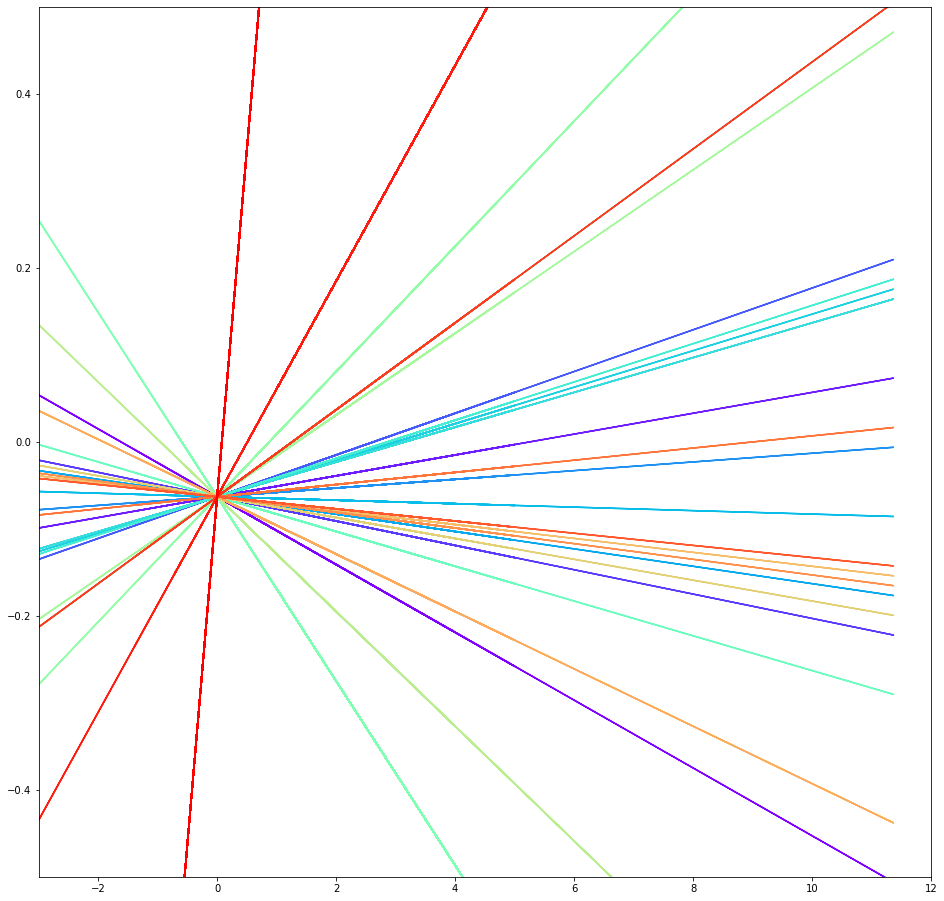

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Убираю предупреждение о количестве графиков
# plt.rcParams.update({'figure.max_open_warning': 0}) 

plt.figure(figsize=(16, 16))
plt.xlim(-3, 12)
plt.ylim(-0.5, 0.5)
colors = cm.rainbow(np.linspace(0, 1, len(x.columns)))

for i in range(len(x.columns)):
    #fig1, ax1 = plt.subplots() 
    plt.plot(x, model.coef_[0][i]*x + model.intercept_[0], c =colors[i], label=x.columns[i])

## 5. Применить алгоритмы кластеризации. 

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
dbscan = DBSCAN(eps=3.14, min_samples=2.5)
# можно понастраивать eps и min_samples, но улучшить разделение на кластеры у меня не получилось.

dbscan.fit(x_train)
pca = PCA(n_components=2).fit(x_train)
pca_2d = pca.transform(x_train)
print(set(dbscan.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


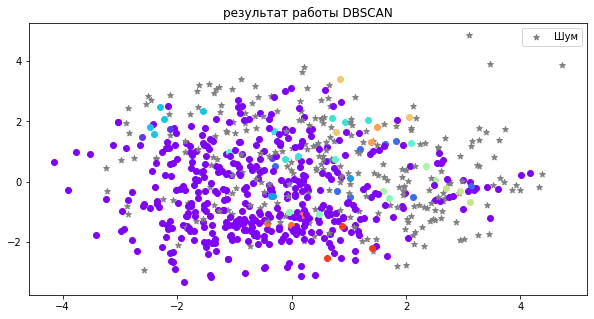

In [17]:
plt.figure(figsize=(10, 5))
#colors = [np.random.rand(3,) for i in set(dbscan.labels_)]
colors = cm.rainbow(np.linspace(0, 1, len(set(dbscan.labels_))))
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == -1:
        c0 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c = 'grey', marker='*')
    else:
        plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c = [colors[dbscan.labels_[i]]], marker='o')
plt.title('результат работы DBSCAN')
plt.legend([c0], ['Шум'])
plt.show()


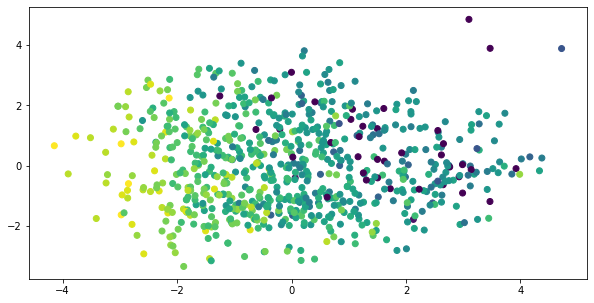

In [18]:
plt.figure(figsize=(10, 5))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=y_train["G3"])

## 6. Что общего между объектами в каждом кластере?

### Пока нет идей, как это делать